In [1]:
import numpy as np

from scipy.signal import fftconvolve
from scipy.interpolate import interp1d
from scipy.optimize import fmin

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------
All data was extracted from Freeman & Fried (2011), Fig. 2

In [2]:
# Data extracted from Fig. 2 of Freeman & Fried (2011)
freeman = dict()

freeman['norm_resp'] = dict()
freeman['norm_resp']['2'] = np.array([1.00000, 1.00000, 2.02247, 0.71475,
                                        2.98876, 0.68852, 3.95506, 0.65902,
                                        4.94382, 0.63934, 5.91011, 0.62623,
                                        6.89888, 0.62951, 7.88764, 0.62951,
                                        8.87640, 0.62623, 9.86517, 0.61311]).reshape((-1, 2))
freeman['norm_resp']['4'] = np.array([1.00000, 1.00000, 1.97753, 0.69836,
                                        2.98876, 0.60656, 3.95506, 0.58361,
                                        4.92135, 0.54098, 5.91011, 0.52787,
                                        6.89888, 0.53443, 7.93258, 0.52131,
                                        8.89888, 0.51148, 9.86517, 0.51148]).reshape((-1, 2))
freeman['norm_resp']['8'] = np.array([1.00000, 1.00000, 1.97753, 0.59672,
                                        3.03371, 0.52787, 3.97753, 0.47869,
                                        4.94382, 0.43607, 5.93258, 0.43279,
                                        6.92135, 0.40984, 7.88764, 0.37377,
                                        8.87640, 0.38689, 9.86517, 0.36721]).reshape((-1, 2))
freeman['norm_resp']['16'] = np.array([1.03371, 0.98361, 2.00000, 0.66557,
                                         2.98876, 0.48525, 3.97753, 0.42295,
                                         4.96629, 0.37049, 5.93258, 0.32787,
                                         6.92135, 0.31475, 7.93258, 0.29508,
                                         8.87640, 0.28197, 9.91011, 0.28197]).reshape((-1, 2))

freeman['long_term'] = np.array([0.08333, 3.76415, 0.08333, 3.56604,
                                 0.05556, 3.24528, 0.08333, 2.96226,
                                 0.11111, 2.60377, 0.19444, 2.34906,
                                 0.19444, 2.11321, 0.27778, 1.83019,
                                 0.41667, 1.63208, 0.91667, 1.50000,
                                 2.08333, 1.43396, 3.72222, 1.36792,
                                 5.94444, 1.30189, 8.11111, 1.26415,
                                 10.55556, 1.18868, 12.83333, 1.13208,
                                 15.16667, 1.08491, 17.19444, 1.05660,
                                 18.50000, 1.07547]).reshape((-1, 2))

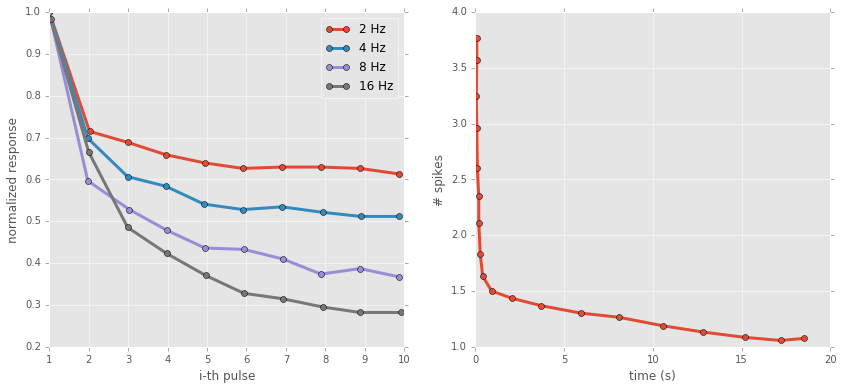

In [3]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
for cond in ['2', '4', '8', '16']:
    plt.plot(freeman['norm_resp'][cond][:, 0], freeman['norm_resp'][cond][:, 1], 'o-',
             linewidth=3, label=cond + ' Hz')
plt.xlabel('i-th pulse')
plt.ylabel('normalized response')
plt.legend()

plt.subplot(122)
plt.plot(freeman['long_term'][:, 0], freeman['long_term'][:, 1], 'o-', linewidth=3)
plt.xlabel('time (s)')
plt.ylabel('# spikes')

# Fitting their plot
----------------------------

Just trying to make sure I got the double exponent right. Trying to fit their data from Fig. 8A.

In [4]:
def double_exp(x, k1, tau1, k2, tau2):
    return k1 * np.exp(-x * tau1) + k2 * np.exp(-x * tau2)

In [5]:
def mse_double_exp(x):
    [k1, tau1, k2, tau2] = x
    
    xtest = freeman['long_term'][:, 0]
    ytest = freeman['long_term'][:, 1]
    
    yhat = double_exp(xtest, k1, tau1, k2, tau2)
    return np.mean(np.abs(yhat - ytest) ** 2)

In [6]:
k1, tau1, k2, tau2 = fmin(mse_double_exp, [1.0, 0.15, 1.0, 14.0])
print('k1 = %.4f' % k1)
print('tau1 = %.4f' % tau1)
print('k2 = %.4f' % k2)
print('tau2 = %.4f' % tau2)

Optimization terminated successfully.
         Current function value: 0.038955
         Iterations: 192
         Function evaluations: 331
k1 = 1.4728
tau1 = 0.0191
k2 = 3.1402
tau2 = 7.1345


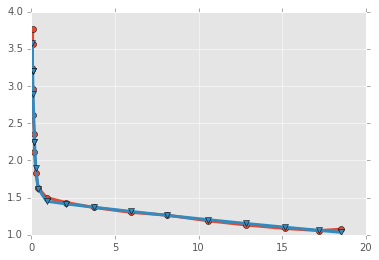

In [7]:
plt.plot(freeman['long_term'][:, 0], freeman['long_term'][:, 1], 'o-', linewidth=3)
plt.plot(freeman['long_term'][:, 0], double_exp(freeman['long_term'][:, 0], k1, tau1, k2, tau2),
         'v-', linewidth=3)

# Model
-----------------

Following are all utily funcions used in this script.

In [8]:
class GanglionCell(ec2b.TemporalModel):
    def __init__(self, tsample, kfast=1.0, kslow=1.0, outweight=1.0):
        tau_inl = 1
        super(GanglionCell, self).__init__(tsample, tau_inl=1.0 / 1000,
                                                   delay_inl=40.0 / 1000,
                                                   lweight=0.1,
                                                   aweight=0.5)
        self.tau_ca_fast = 0.0191
        self.kfast = kfast
        self.tau_ca_slow = 7.1345
        self.kslow = kslow
        self.outweight = outweight
        
        t = np.arange(0, 10 * self.tau_ca_fast, self.tsample)
        self.gamma_ca_fast = e2cm.gamma(1, self.tau_ca_fast, t)

        t = np.arange(0, 10 * self.tau_ca_slow, self.tsample)
        self.gamma_ca_slow = e2cm.gamma(1, self.tau_ca_slow, t)
        
    def calc_per_electrode(self, pt):
        # Don't do charge accumulation here
        return pt.data
    
    def stationary_nonlinearity(self, resp):
        # Instead of this step, do desensitization
        sz = resp.size
        
        # At this point, it's all nonzero
        ca_fast = self.tsample * fftconvolve(resp, self.gamma_ca_fast, mode='full')[:sz]
        ca_slow = self.tsample * fftconvolve(resp, self.gamma_ca_slow, mode='full')[:sz]
        
        resp -= self.kfast * ca_fast + self.kslow * ca_slow
        return resp * self.outweight

In [9]:
class GanglionCellFast(ec2b.TemporalModel):
    def __init__(self, tsample, kfast=1.0, outweight=1.0):
        tau_inl = 1
        super(GanglionCellFast, self).__init__(tsample, tau_inl=1.0 / 1000,
                                                   delay_inl=40.0 / 1000,
                                                   lweight=0.1,
                                                   aweight=0.5)
        self.tau_ca_fast = 0.0191
        self.kfast = kfast
        self.outweight = outweight
        
        t = np.arange(0, 10 * self.tau_ca_fast, self.tsample)
        self.gamma_ca_fast = e2cm.gamma(1, self.tau_ca_fast, t)

        
    def calc_per_electrode(self, pt):
        # Don't do charge accumulation here
        return pt.data
    
    def stationary_nonlinearity(self, resp):
        # Instead of this step, do desensitization
        sz = resp.size
        
        # At this point, it's all nonzero
        ca_fast = self.tsample * fftconvolve(resp, self.gamma_ca_fast, mode='full')[:sz]
        
        resp -= self.kfast * ca_fast
        return resp * self.outweight

# Fit
----------

In [10]:
def run_model(k1, implant, retina):
    pdur = 1.0 / 1000
    amp = 20
    
    tsample = 0.005 / 1000
    gcr = GanglionCellFast(tsample, kfast=k1, outweight=1.0)

    model = dict()
    model['norm_resp'] = dict()
    for freq in [2, 4, 8, 16]:
        freqstr = str(freq)
        stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=10.0 / freq,
                                      pulse_dur=pdur, interphase_dur=0,
                                      pulsetype='cathodicfirst',
                                      delay=20.0 / 1000)
        mov = ec2b.pulse2percept(stim, implant, gcr, retina, use_ecs=False,
                                 rsample=1, dojit=True)
        resp = np.squeeze(mov.data)
        freq_size = int(resp.size / 10.0)
        peaks = []
        for f in range(10):
            slc = resp[f*freq_size: (f + 1) * freq_size]
            peaks.append(slc.max())

        model['norm_resp'][freqstr] = peaks / peaks[0]
        
    return model

In [11]:
def mse_model_fast(x, implant, retina, freeman):
    print(x)
    k1 = x
    model = run_model(k1, implant, retina)
    
    mse = 0
    for freq in [2, 4, 8, 16]:
        cond = str(freq)
        mse += np.mean(np.abs(model['norm_resp'][cond] - freeman['norm_resp'][cond][:, 1]) ** 2)
        
    print(mse)
    return mse

In [12]:
implant = e2cm.ElectrodeArray('epiretinal', 40.0 / 2, -500, -500, 25.0)

r_sampling = 100
axon_lambda = 2 
retina = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=0,
                     xlo=implant[0].x_center, xhi=implant[0].x_center,
                     ylo=implant[0].y_center, yhi=implant[0].y_center)

In [13]:
xopt = fmin(mse_model_fast, [1.0], args=(implant, retina, freeman))

2017-02-03 18:46:52,383 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


[ 1.]


2017-02-03 18:46:53,003 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:53,315 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:53,627 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:53,860 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.336721985024
[ 1.05]


2017-02-03 18:46:54,380 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:54,798 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:55,116 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:55,351 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.352992959754
[ 0.95]


2017-02-03 18:46:55,873 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:56,288 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:56,603 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:56,840 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.376301627753
[ 1.025]


2017-02-03 18:46:57,361 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:57,776 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:58,090 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:58,324 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.33682102622
[ 0.975]


2017-02-03 18:46:58,841 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:59,162 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:59,478 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:46:59,714 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.350540390137
[ 1.0125]


2017-02-03 18:47:00,236 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:00,655 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:00,970 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:01,204 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.334901453564
[ 1.025]


2017-02-03 18:47:01,724 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:02,042 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:02,357 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:02,593 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.33682102622
[ 1.00625]


2017-02-03 18:47:03,117 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:03,535 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:03,850 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:04,086 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.335360947386
[ 1.01875]


2017-02-03 18:47:04,608 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:05,033 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:05,348 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:05,581 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.335376807054
[ 1.009375]


2017-02-03 18:47:06,103 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:06,420 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:06,733 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:06,969 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.335016440092
[ 1.015625]


2017-02-03 18:47:07,491 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:07,911 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:08,226 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:08,449 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.335020165621
[ 1.0109375]


2017-02-03 18:47:08,964 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:09,274 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:09,582 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:09,802 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.334929997516
[ 1.0140625]


2017-02-03 18:47:10,316 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:10,730 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:11,043 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:11,273 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.334931335995
[ 1.01171875]


2017-02-03 18:47:11,795 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:12,106 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:12,320 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:12,554 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.334908454157
[ 1.01328125]


2017-02-03 18:47:13,069 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:13,387 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:13,701 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:13,935 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.334909059487
[ 1.01210938]


2017-02-03 18:47:14,455 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:14,774 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:15,088 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:15,324 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.334903138264
[ 1.01289062]


2017-02-03 18:47:15,843 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:16,160 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:16,472 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:16,707 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.334903432807
[ 1.01230469]


2017-02-03 18:47:17,231 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:17,650 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:17,967 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:18,198 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.334901836343
[ 1.01269531]


2017-02-03 18:47:18,721 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:19,038 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:19,350 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:19,585 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.334901989677
[ 1.01240234]


2017-02-03 18:47:20,107 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:20,525 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:20,841 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


0.334901540805
Optimization terminated successfully.
         Current function value: 0.334901
         Iterations: 10
         Function evaluations: 20


In [14]:
xopt

array([ 1.0125])

# Plot
----------

In [15]:
model = run_model(xopt, implant, retina)

2017-02-03 18:47:21,156 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:21,676 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:21,990 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected
2017-02-03 18:47:22,309 [pulse2percept.effectivecurrent2brightness] [INFO] tol=5.0%, 1/1 px selected


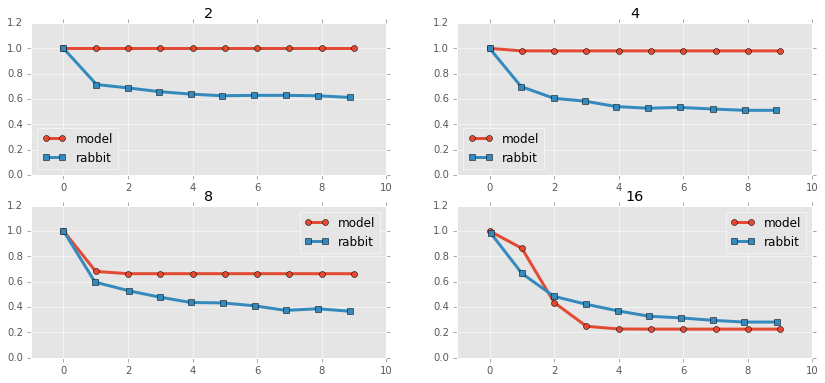

In [17]:
num_cols = np.floor(np.sqrt(len(model['norm_resp'])))
num_rows = np.ceil(len(model['norm_resp']) / num_cols)
plt.figure(figsize=(14, 6))
for i, freq in enumerate([2, 4, 8, 16]):
    freqstr = str(freq)
    plt.subplot(num_rows, num_cols, i + 1)
    plt.plot(model['norm_resp'][freqstr], 'o-',
             linewidth=3, label='model')
    plt.plot(freeman['norm_resp'][freqstr][:, 0] - 1,
             freeman['norm_resp'][freqstr][:, 1], 's-',
             linewidth=3, label='rabbit')
    plt.title(freqstr)
    plt.ylim(0, 1.2)
    plt.xlim(-1, 10)
    plt.legend(loc='best')